In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("datasets/exchange_rate.csv")
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [4]:
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

In [5]:
df.duplicated().sum()

0

<Axes: >

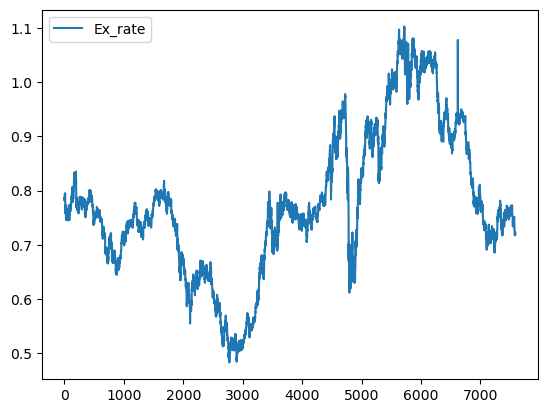

In [6]:
df.plot()

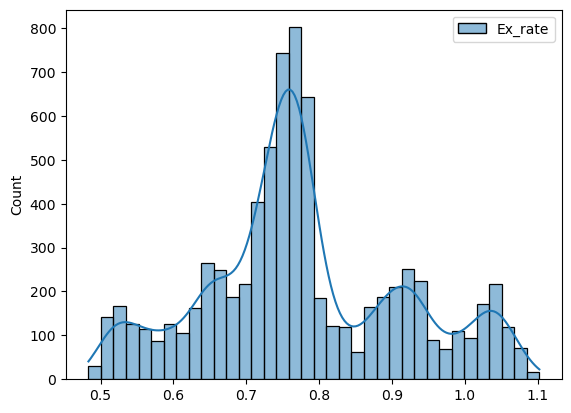

In [7]:
sb.histplot(df, kde=True)
plt.show()

In [8]:
# Extract the year from the 'Date' column

df['year'] = pd.to_datetime(df['date'], format="%d-%m-%Y %H:%M").dt.year
df.head()

,date,Ex_rate,year
0,01-01-1990 00:00,0.7855,1990
1,02-01-1990 00:00,0.7818,1990
2,03-01-1990 00:00,0.7867,1990
3,04-01-1990 00:00,0.7860,1990
4,05-01-1990 00:00,0.7849,1990


In [9]:
df['Ex_rate'].describe()

count    7588.000000
mean        0.776974
std         0.136620
min         0.483297
25%         0.701422
50%         0.761377
75%         0.873477
max         1.102536
Name: Ex_rate, dtype: float64

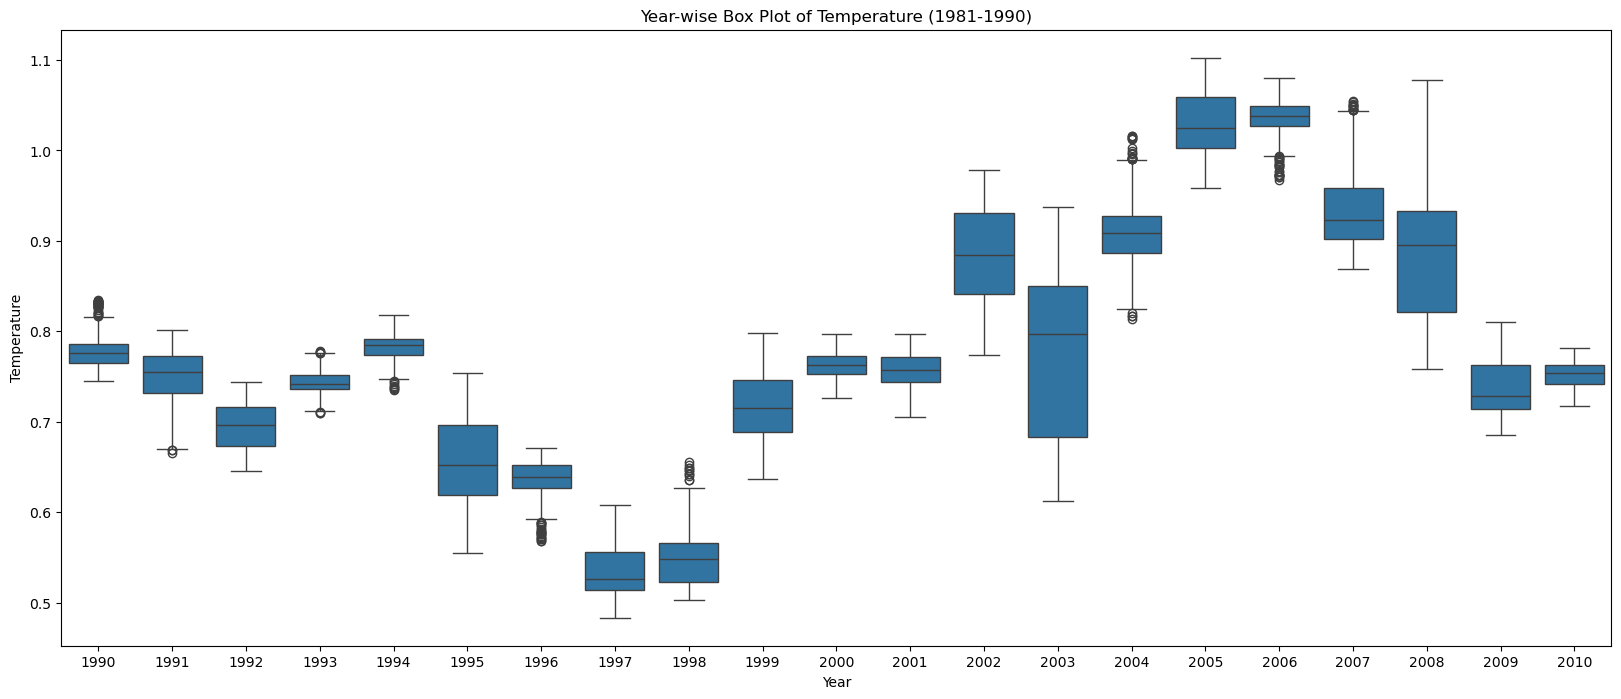

In [10]:
# Create a box plot using seaborn

plt.figure(figsize=(20, 8))
sb.boxplot(x='year', y='Ex_rate', data=df)
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Year-wise Box Plot of Temperature (1981-1990)')
plt.show()

In [11]:
def get_limits(sub_df):
    Q1 = np.percentile(sub_df,25)
    Q3 = np.percentile(sub_df,75)
    IQR = Q3 - Q1
    lower_limit = Q1 - (1.5*IQR)
    upper_limit = Q3 + (1.5*IQR) 
    
    return lower_limit, upper_limit

In [12]:
def check_outliers(sub_df, yy, LL, UL):
    
    if sub_df[ (sub_df['Ex_rate']>UL) | (sub_df['Ex_rate']<LL) ].shape[0] > 0 :   
        return True
    else:
        return False  

In [13]:
outlier_variables = df.groupby(by='year')
new_df = pd.DataFrame()

for yr in outlier_variables:
    filtered_df = df.loc[df['year'] == yr[0]]
    
    LL, UL = get_limits(filtered_df['Ex_rate'])
    flag = check_outliers(filtered_df, yr, LL, UL)
    
    if flag == True:               
        filtered_df.loc[ filtered_df['Ex_rate']>UL, 'Ex_rate' ] = UL         
        filtered_df.loc[ filtered_df['Ex_rate']<LL, 'Ex_rate' ] = LL 
        
    new_df = pd.concat([new_df, filtered_df])

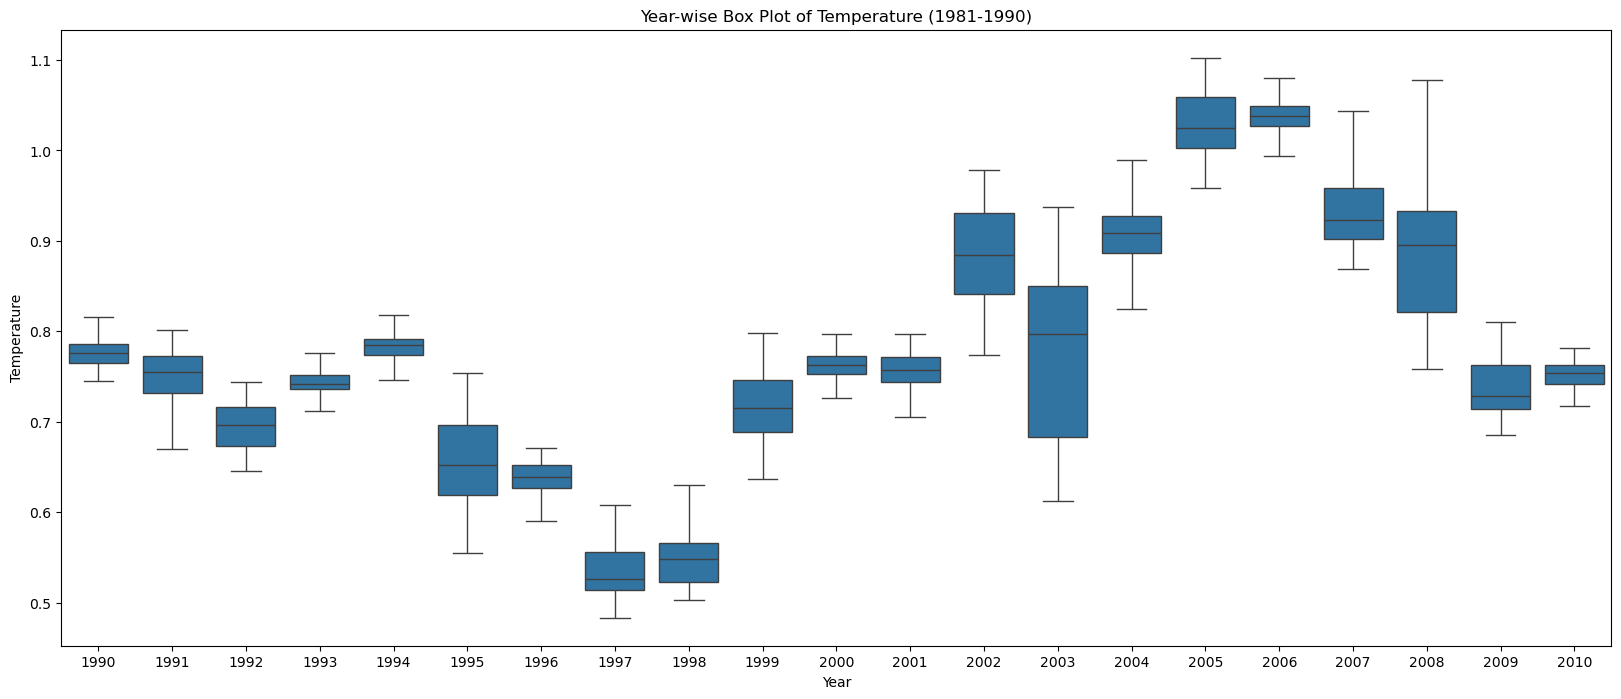

In [14]:
# Create a box plot using seaborn

plt.figure(figsize=(20, 8))
sb.boxplot(x='year', y='Ex_rate', data=new_df)
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Year-wise Box Plot of Temperature (1981-1990)')
plt.show()

In [15]:
from statsmodels.tsa.stattools import adfuller

def adf_test(new_df):
    result = adfuller(new_df)
    return {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4]
    }

# Run ADF Test on original data
adf_result_original = adf_test(new_df['Ex_rate'])
adf_result_original

{'ADF Statistic': -1.6477764043401655,
 'p-value': 0.45820035238563056,
 'Critical Values': {'1%': -3.4312123140180137,
  '5%': -2.861921078147796,
  '10%': -2.5669728434336108}}

Ho: Data is Non Stationary

H1: Data is Stationary

if p values < 0.05 , Ho is rejected and H1 is accepted
if p values > 0.05 , H1 is rejected and Ho is accepted
✅ Interpretation:

Since p-value (0.458) > 0.05, we fail to reject the null hypothesis.

Conclusion: The exchange_rate series is non-stationary.

To make it stationary, we must difference the data.

In [17]:
exchange_diff = new_df['Ex_rate'].diff().dropna()
exchange_diff.head()

1   -0.0037
2    0.0049
3   -0.0007
4   -0.0011
5    0.0017
Name: Ex_rate, dtype: float64

In [18]:

# Run ADF Test on original data
adf_result_original = adf_test(exchange_diff)
adf_result_original

{'ADF Statistic': -99.67254718763758,
 'p-value': 0.0,
 'Critical Values': {'1%': -3.4312123140180137,
  '5%': -2.861921078147796,
  '10%': -2.5669728434336108}}

In [19]:
from statsmodels.tsa.arima.model import ARIMA

# Step 6: Fit AR Model
# (p=1, d=0, q=0) -> AR(1) model

ar_model = ARIMA(new_df['Ex_rate'], order=(1,0,0))
ar_model_fit = ar_model.fit()

# Summary of AR model
ar_summary = ar_model_fit.summary()

print("AIC: ",ar_model_fit.aic)
print("BIC: ",ar_model_fit.bic)

# Calculate RMSE using the fitted values and original data
from sklearn.metrics import mean_squared_error
import numpy as np
rmse = np.sqrt(mean_squared_error(new_df['Ex_rate'], ar_model_fit.fittedvalues))
print("RMSE:",rmse)

AIC:  -56091.29930160102
BIC:  -56070.49633160786
RMSE: 0.006001978461574983


In [20]:

ma_model = ARIMA(new_df['Ex_rate'], order=(0,0,1))
ma_model_fit = ma_model.fit()

# Summary of MA model
ma_summary = ma_model_fit.summary()

print("AIC: ",ma_model_fit.aic)
print("BIC: ",ma_model_fit.bic)

# Calculate RMSE using the fitted values and original data
from sklearn.metrics import mean_squared_error
import numpy as np
rmse = np.sqrt(mean_squared_error(new_df['Ex_rate'], ma_model_fit.fittedvalues))
print("RMSE:",rmse)

AIC:  -18659.62435927309
BIC:  -18638.821389279925
RMSE: 0.07071776846887028


In [21]:
# (p=1, d=1, q=1) -> ARIMA(1,1,1) model

arima_model = ARIMA(new_df['Ex_rate'], order=(1,1,1))
arima_model_fit = arima_model.fit()

# Summary of ARIMA model
arima_summary = arima_model_fit.summary()
# Successfully fitted an AutoRegressive Integrated Moving Average (ARIMA) model.

print("AIC: ",arima_model_fit.aic)
print("BIC: ",arima_model_fit.bic)

# Calculate RMSE using the fitted values and original data
from sklearn.metrics import mean_squared_error
import numpy as np
rmse = np.sqrt(mean_squared_error(new_df['Ex_rate'], arima_model_fit.fittedvalues))
print("RMSE:",rmse)

AIC:  -56223.37430478069
BIC:  -56202.57173017468
RMSE: 0.01080261932307022


In [22]:
# compare the performance in between three models
from sklearn.metrics import mean_squared_error
import numpy as np

# Helper function to calculate RMSE
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# Predictions (In-sample) for training data
ar_pred_in_sample = ar_model_fit.predict(start=new_df.index[0], end=new_df.index[-1])
ma_pred_in_sample = ma_model_fit.predict(start=new_df.index[0], end=new_df.index[-1])
arima_pred_in_sample = arima_model_fit.predict(start=new_df.index[0], end=new_df.index[-1])

# Metrics Calculation
metrics = {
    'Model': ['AR(1)', 'MA(1)', 'ARIMA(1,1,1)'],
    'AIC': [
        ar_model_fit.aic,
        ma_model_fit.aic,
        arima_model_fit.aic
    ],
    'BIC': [
        ar_model_fit.bic,
        ma_model_fit.bic,
        arima_model_fit.bic
    ],
    'RMSE': [
        calculate_rmse(new_df['Ex_rate'], ar_pred_in_sample),
        calculate_rmse(new_df['Ex_rate'], ma_pred_in_sample),
        calculate_rmse(new_df['Ex_rate'], arima_pred_in_sample)
    ]
}

metrics_df = pd.DataFrame(metrics)
metrics_df


,Model,AIC,BIC,RMSE
0,AR(1),-56091.299302,-56070.496332,0.006002
1,MA(1),-18659.624359,-18638.821389,0.070718
2,"ARIMA(1,1,1)",-56223.374305,-56202.571730,0.010803
